# Chapter 1: Greenhouse Gase - The prime suspect

### Different Datasets, Different Conclusions?

In the previous section we identified an increase in the GreenHouse Gases (GHG), based on the data provide by satellite measurements. Let's see how the concentrations evolve when we use another data source, in particular the CAMS global greenhouse gas reanalysis dataset.

In this tutorial we will:
1. Search, download, and view data freely available in [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/home) and [Atmosphere Data Store](https://ads.atmosphere.copernicus.eu/cdsapp#!/home).
2. Calculate global and regional monthly timeseries.
3. Mask the data and use spatiotemporal subsets for plotting.
3. View time series and analyse trends.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ECMWFCode4Earth/sketchbook-earth/main?labpath=tutorials/01_greenhouse_gases/01b_greenhouse_gases.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/01_greenhouse_gases/01b_greenhouse_gases.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/01_greenhouse_gases/01b_greenhouse_gases.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

-----------

<div class="alert alert-block alert-warning">
    
<b>NOTE</b>: <br>
A big chunk of this notebook is overlapping with the first part of this chapter. This was selected so that this part can run independatly by any user, without the need to previosly run the former part.
</div>

### Section 1. Install & import the necessary packages.

The first step for being able to analyse and plot the data is to download and import the necessary libraries for this tutorial. In the GitHub repository you can find the full environment that has all the libraries needed for this and the other tutorials. The environment can be installed in Linux with the simple command: `conda env create -f environment.yml`. This would be the best option if you use this and the rest tutorials on your local computer. If you are using this tutorial in Google Colab most of the required libraries are already preinstalled in the environment and there are only few libraries that should be downloaded.

<div class="alert alert-block alert-warning">
    
<b>NOTE</b>: <br>
After you execute the below cell you might be prompted by Google Colab to "Restart the Runtime". If this happens, please restart the runtime and move on the next cell.
</div>

In [1]:
# download libraries not available in the default Google Colab environment
%pip install cdsapi

# need some extra arguments for intalling cartopy otherwise some features of this library break the script if it is run in Google Colab 
%pip install shapely cartopy --no-binary shapely --no-binary cartopy --force # more info at https://github.com/SciTools/cartopy/issues/1490

Let's now import all the required libraries in our environment. We categorized the libraries based on that they are used for: general libraries, libraries for data analysis, and plotting libraries.

In [1]:
# General libraries
from string import ascii_lowercase as ABC # String operations
import datetime # date
import calendar # date calculations
import zipfile # for unzipping data
import os # operating system interfaces library
import cdsapi # CDS API
import urllib3 # Disable warnings for data download via API
urllib3.disable_warnings()

# Libraries for working with multidimensional arrays
import numpy as np # for n-d arrays
import pandas as pd # for 2-d arrays (including metadata for the rows & columns)
import xarray as xr # for n-d arrays (including metadata for all the dimensions)

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.geoaxes

The below is for having a consistent plotting across all tutorials. It **will NOT work in Google Colab** or other cloud services, unless you include the file (available in the Github repository) in the cloud and in the same directory as this notebook, and use the correct path, e.g.
`plt.style.use('copernicus.mplstyle')`.

In [2]:
plt.style.use('../copernicus.mplstyle') # use the predefined matplotlib style for consistent plotting across all tutorials

### Section 2. Download and preprocess data from CDS and ADS.

Let's create a folder were all the data will be stored.

In [3]:
dir_loc = 'data/' # assign folder for storing the downloaded data
os.makedirs(dir_loc, exist_ok=True) # create the folder if not available

#### Get data from CDS

Enter CDS API key


We will request data from the Climate Data Store (CDS) programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. The string of characters that make up your KEY include your personal User ID and CDS API key. To obtain these, first register or login to the CDS (http://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with that string.

In [4]:
# CDS key
cds_url = 'https://cds.climate.copernicus.eu/api/v2'
cds_key = '########' # please add your key here the format should be as {uid}:{api-key}

Get GHG data from the satellite products, that are available at CDS.
In CDS a user can browse all available data from the search option, and once the selected dataset is identified, one can see from the download tab the exact API request. For example in [this link](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-methane?tab=form) you can see the satellite methane data. For this tutorial we used the options:
- Processing level: Level 3
- Variable: Column-averaged dry-air mixing ratios of methane (XCH4) and related variables
- Version: 4.4
- Format: zip

In [5]:
c = cdsapi.Client(url=cds_url, key=cds_key)

c.retrieve(
    'satellite-methane',
    {
        'format': 'zip',
        'processing_level': 'level_3',
        'sensor_and_algorithm': 'merged_obs4mips',
        'version': '4.4',
        'variable': 'xch4',
    },
    f'{dir_loc}satellites_CH4.zip')

c.retrieve(
    'satellite-carbon-dioxide',
    {
        'format': 'zip',
        'processing_level': 'level_3',
        'sensor_and_algorithm': 'merged_obs4mips',
        'version': '4.4',
        'variable': 'xco2',
    },
    f'{dir_loc}satellites_CO2.zip')

2023-06-24 20:35:51,245 INFO Welcome to the CDS
2023-06-24 20:35:51,246 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-methane
2023-06-24 20:35:51,829 INFO Request is completed
2023-06-24 20:35:51,830 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data7/dataset-satellite-methane-9e933b79-0a27-4f67-bc8e-a998a1580be3.zip to data/satellites_CH4.zip (15.1M)
2023-06-24 20:36:02,142 INFO Download rate 1.5M/s   
2023-06-24 20:36:02,380 INFO Welcome to the CDS
2023-06-24 20:36:02,381 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-carbon-dioxide
2023-06-24 20:36:03,012 INFO Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data5/dataset-satellite-carbon-dioxide-b104dd8a-ea1d-4b6d-b68d-32edda46a5f1.zip to data/satellites_CO2.zip (12.2M)
2023-06-24 20:36:20,484 INFO Download rate 717.3K/s 


Result(content_length=12831918,content_type=application/zip,location=https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data5/dataset-satellite-carbon-dioxide-b104dd8a-ea1d-4b6d-b68d-32edda46a5f1.zip)

The data are downloaded in zip format. Let's unzip them and rename them with an intuitive name.

In [5]:
# unzip the satellite data, rename the file and delete the original zip
for i_ghg in ['CO2', 'CH4']: # loop through both variables
    with zipfile.ZipFile(f'{dir_loc}satellites_{i_ghg}.zip','r') as zip_ref:
        zip_ref.extractall(dir_loc) # unzip file
        source_file = '200301_202112-C3S-L3_GHG-GHG_PRODUCTS-MERGED-MERGED-OBS4MIPS-MERGED-v4.4.nc' # the name of the unzipped file
        os.rename(f'{dir_loc}{source_file}', f'{dir_loc}satellites_{i_ghg}.nc') # rename to more intuitive name
        os.remove(f'{dir_loc}satellites_{i_ghg}.zip') # delete original zip file

# read the data with xarray
co2_satellites = xr.open_dataset(f'{dir_loc}satellites_CO2.nc')
ch4_satellites = xr.open_dataset(f'{dir_loc}satellites_CH4.nc')

Let's observe how the satellite data looks like. Notice that the grid is 5 degrees lot, lat, and that the time coordinate refers to the middle day of the relevant month. There are also a lot of different variable, including the CO2 values and standard deviations related to the uncertainty.

In [6]:
co2_satellites

<xarray.Dataset>
Dimensions:                  (time: 228, bnds: 2, lat: 36, lon: 72, pressure: 10)
Coordinates:
  * time                     (time) datetime64[ns] 2003-01-16T12:00:00 ... 20...
  * lat                      (lat) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon                      (lon) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Dimensions without coordinates: bnds, pressure
Data variables:
    time_bnds                (time, bnds) datetime64[ns] ...
    lat_bnds                 (lat, bnds) float64 ...
    lon_bnds                 (lon, bnds) float64 ...
    pre                      (pressure) float64 ...
    pre_bnds                 (pressure, bnds) float64 ...
    land_fraction            (lat, lon) float64 ...
    xco2                     (time, lat, lon) float32 ...
    xco2_nobs                (time, lat, lon) float64 ...
    xco2_stderr              (time, lat, lon) float32 ...
    xco2_stddev              (time, lat, lon) float32 ...
    column_averaging_kernel  (time, pressure, lat, lon) float32 ...
    vmr_profile_co2_apriori  (time, pressure, lat, lon) float32 ...
Attributes: (12/28)
    activity_id:            obs4MIPs
    comment:                Since long time, climate modellers use ensemble a...
    contact:                Maximilian Reuter (maximilian.reuter@iup.physik.u...
    Conventions:            CF-1.7 ODS-2.1
    creation_date:          2022-07-10T09:25:22Z
    data_specs_version:     2.1.0
    ...                     ...
    source_version_number:  v4.4
    title:                  C3S XCO2 v4.4
    tracking_id:            ca42b88b-c774-4a16-9ad8-a49f9a4839fd
    variable_id:            xco2
    variant_info:           Best Estimate
    variant_label:          BE

<div class="alert alert-block alert-warning">
    
<b>NOTE</b>: <br>
The selected datasets have data up to 2021. For the ones interested in expanding the data with near-real time information, satellite measurements for the recent period are available [here](http://www.iup.uni-bremen.de/~ghguser/gosat_focal.php).  
</div>

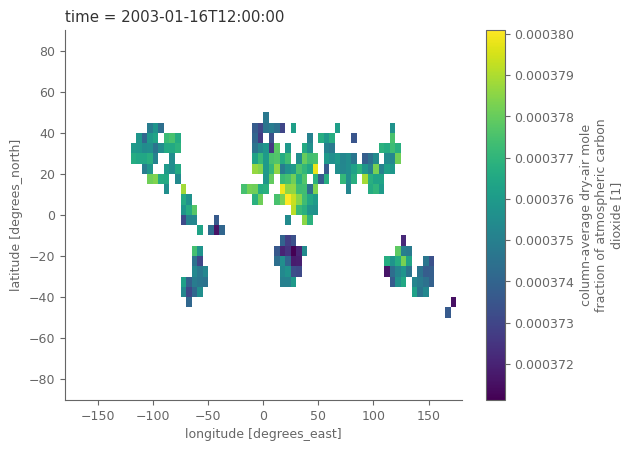

In [7]:
# "quick and dirty" plot of the data
co2_satellites['xco2'].isel(time=0).plot() 

Since we have a different variable for each GHG it is easier to combine them both in one variable.

In [8]:
# monthly sampled, spatially resolved GHG concentration in the atmosphere
concentration = xr.merge([co2_satellites['xco2'], ch4_satellites['xch4']]).to_array('ghg')

# associated land fraction; is the same for CO2 and CH4
land_fraction = co2_satellites['land_fraction']
is_land_sat = land_fraction >= 0.5  # anything with land_fraction at least 50% is considered as land
is_land_sat.name = 'is_land'

concentration.to_dataset('ghg') # for briefly checking the variable its better to see it as 'dataset' so that it's visually nicer

<xarray.Dataset>
Dimensions:  (time: 228, lat: 36, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-16T12:00:00 ... 2021-12-16T12:00:00
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
Data variables:
    xco2     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    xch4     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    standard_name:  dry_atmosphere_mole_fraction_of_carbon_dioxide
    long_name:      column-average dry-air mole fraction of atmospheric carbo...
    units:          1
    cell_methods:   time: mean
    fill_value:     1e+20
    comment:        Satellite retrieved column-average dry-air mole fraction ...

Clearly, after merging the `attrs` of the `DataArray` are not correct anymore, so let's quickly adapt them:

In [9]:
concentration = concentration.assign_attrs({
    'standard_name': 'dry_atmosphere_mole_fraction',
    'long_name': 'column-average dry-air mole fraction',
    'comment': 'Satellite retrieved column-average dry-air mole fraction'
})

In [10]:
# change temporal coordinates to refer to the start of the month
concentration = concentration.assign_coords( {'time': pd.to_datetime(concentration.time.dt.strftime('%Y%m01'))} ) # date at start of month

concentration.time

<xarray.DataArray 'time' (time: 228)>
array(['2003-01-01T00:00:00.000000000', '2003-02-01T00:00:00.000000000',
       '2003-03-01T00:00:00.000000000', ..., '2021-10-01T00:00:00.000000000',
       '2021-11-01T00:00:00.000000000', '2021-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2021-12-01

Note on values over ocean: water is a bad reflector in the short-wave infrared spectral region and requires a specific observation mode. Not all satellites that this dataset is based on have this specific mode which is why we consider **values over land only** in the following.

In [11]:
concentration = concentration.where(is_land_sat)

#### Get data from ADS

Besides satellite measurements for the GHG there are also global reanalysis products providing information about CO2 and CH4. Let's use the one available in the Atmosphere Data Store (ADS).</br>
As we did with the CDS API, the same is also needed for the ADS, with a new registration to be completed at https://ads.atmosphere.copernicus.eu/api-how-to.

In [12]:
# ADS key
ads_url = 'https://ads.atmosphere.copernicus.eu/api/v2'
ads_key = '########' # please add your key here the format should be as {uid}:{api-key}

Get GHG data from reanalysis [(EGG4) from ADS](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-ghg-reanalysis-egg4-monthly?tab=overview). We use the monthly mean data for speeding the process. For the ones interested there is also a [daily dataset](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-ghg-reanalysis-egg4?tab=overview) available. 

In [42]:
# get monthly mean grennhouse gases data from Atmosphere Data Store (it takes around 2 minutes)
c = cdsapi.Client(url=ads_url, key=ads_key)

c.retrieve(
    'cams-global-ghg-reanalysis-egg4-monthly',
    {
     'product_type': 'monthly_mean',
     'variable': ['ch4_column_mean_molar_fraction', 'co2_column_mean_molar_fraction'], # get the available variables
     'year': list(range(2003, 2021)), # get all available years (2003, 2004, ..., 2020)
     'month': list(range(1, 13)), # get all months Jan (1) up to Dec (12)
     'format': 'netcdf',
    },
    f'{dir_loc}greenhouse_gases.nc')

2023-06-24 20:39:06,444 INFO Welcome to the CDS
2023-06-24 20:39:06,445 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-ghg-reanalysis-egg4-monthly
2023-06-24 20:39:06,610 INFO Request is completed
2023-06-24 20:39:06,611 INFO Downloading https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data1/adaptor.mars.external-1683983665.986999-18127-5-994cf598-7b63-4f76-915e-6310a89f2575.nc to data/greenhouse_gases.nc (95.3M)
2023-06-24 20:40:08,565 INFO Download rate 1.5M/s   


Result(content_length=99952612,content_type=application/x-netcdf,location=https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data1/adaptor.mars.external-1683983665.986999-18127-5-994cf598-7b63-4f76-915e-6310a89f2575.nc)

In [22]:
# open the GHG data and inspect the Dataset
# when the data are opened as below using "with" then the link to the actual dataset is closed, meaning that any other program can also access the file in the directory
# this is not the case for the normal opening of the file, as for the co2_satellites in the main section of this tutorial.
with xr.open_dataset(f'{dir_loc}greenhouse_gases.nc') as ghg_reanalysis:
    pass
ghg_reanalysis

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 241, time: 216)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2020-12-01
Data variables:
    tcch4      (time, latitude, longitude) float32 ...
    tcco2      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-13 13:14:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

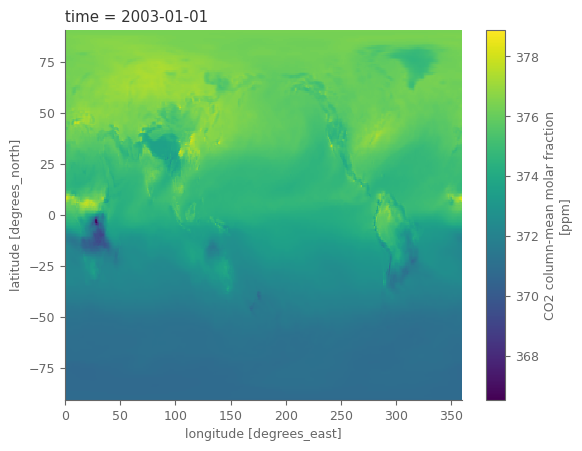

In [23]:
# "quick and dirty" plot of the data
ghg_reanalysis['tcco2'].isel(time=0).plot()

As we can notice, the dataset is a 3-dimensional cube (latitude, longitude, time) with information for two variables (C02, CH4). Also the spatial grid is 0.75 degrees and the data are also over the oceans. We see that this dataset has therefore some differences with the data from the satellites. This will make the task slightly more challenging, but its always nice to be able to see the results with more than 1 datasets... :)

Before rearanging the reanalysis data so that there are no (imortant) differences with the satellite data, let's download the land mask from CDS. This is needed because the GHG measurements from the satellites are not available/reliable over the oceans. So we want to use also a mask for when using GHG data from the reanalysis dataset available from ADS. Note that the resolution (grid) should be specified, because the original one (0.25) is different that the resolution of GHG (0.75).

In [46]:
c = cdsapi.Client(url=cds_url, key=cds_key)

# we just need one random slice of land-sea mask (data are same for all time steps)
c.retrieve(
    'reanalysis-era5-single-levels',
    {
     'product_type': 'reanalysis',
     'variable': 'land_sea_mask',
     'year': '2009',
     'month': '10',
     'day': '16',
     'time': '00:00',
     'grid': [0.75, 0.75], # grid is specified because the default resolution is different
     'format': 'netcdf',
    },
    f'{dir_loc}land_sea_mask.nc')

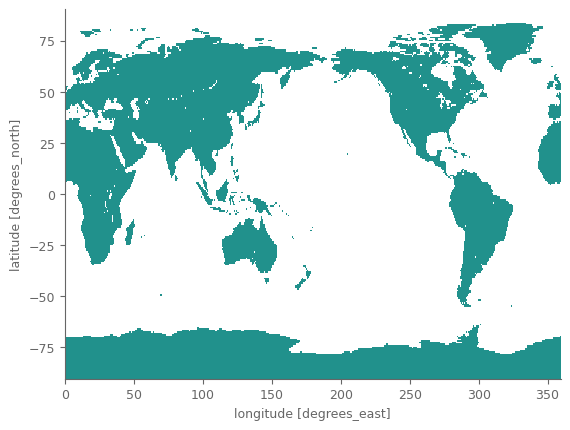

In [24]:
# read the land-sea mask and visualize ("quick and dirty") the data
data_mask = xr.open_dataarray(f'{dir_loc}land_sea_mask.nc').isel(time=0, drop=True)
is_land_rean = data_mask >= 0.5 # make data boolean (1-land, 0-sea), by converting all cells with at least 50% land, as only land
is_land_rean.where(is_land_rean).plot(add_colorbar=False) # plot only the land grid cells

Now we are ready to rearrange the reanalysis data.

In [25]:
ghg_reanalysis_land = ghg_reanalysis.where(is_land_rean) # keep only land data
ghg_reanalysis_land = ghg_reanalysis_land.sortby('latitude') # sort ascending
ghg_reanalysis_land = ghg_reanalysis_land.rename({'latitude': 'lat', 'longitude': 'lon'}) # rename same as satellite coordinates
ghg_reanalysis_land = ghg_reanalysis_land.rename({'tcch4': 'xch4', 'tcco2': 'xco2'}) # rename same as satellite names
ghg_reanalysis_land = ghg_reanalysis_land.to_array('ghg')
ghg_reanalysis_land.to_dataset('ghg')

<xarray.Dataset>
Dimensions:  (time: 216, lat: 241, lon: 480)
Coordinates:
  * lon      (lon) float32 0.0 0.75 1.5 2.25 3.0 ... 357.0 357.8 358.5 359.2
  * lat      (lat) float32 -90.0 -89.25 -88.5 -87.75 ... 87.75 88.5 89.25 90.0
  * time     (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2020-12-01
Data variables:
    xch4     (time, lat, lon) float32 1.624e+03 1.624e+03 1.624e+03 ... nan nan
    xco2     (time, lat, lon) float32 370.8 370.8 370.8 370.8 ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-13 13:14:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### Section 3. Calculate and plot the GHG concentrations

We will calculate the monthly averages of global and regional GHG concentration.

#### Focus on sub-polar regions

In this particular example, we focus on **latitudes between 60N and 60S**. 

In [26]:
region_of_interest = {
    'Global': {'lat': slice(-60, 60), 'lon': slice(-180, 180)},
    'Northern Hemishpere': {'lat': slice(0, 60), 'lon': slice(-180, 180)},
    'Southern Hemisphere': {'lat': slice(-60, 0), 'lon': slice(-180, 180)}
}

Generate auxiliary data used for preprocessing and plotting.

In [27]:
prop_cycle_clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']

aux_var = {
    'xco2': {
        'name':'Atmospheric carbon dioxide', 'units': 'ppm', 'unit_factor': 1e6, # unit factor cause data are not in the unit of interest
        'shortname': r'CO$_{2}$', 'color': prop_cycle_clrs[0], 'ylim': (370, 420), 'ylim_growth': (0, 4)
    },
    'xch4': {
        'name':'Atmospheric methane', 'units': 'ppb', 'unit_factor': 1e9,
        'shortname': r'CH$_{4}$', 'color': prop_cycle_clrs[1], 'ylim': (1725, 1950), 'ylim_growth': (-5, 25)
    },
}

#### Spatial average

Moving on with the spatial averaging now.

The data are projected in lat/lon system. This system does not have equal areas for all grid cells, but as we move closer to the poles, the areas of the cells are reducing. These differences can be accounted when weighting the cells with the cosine of their latitude.
Let's create a function for calculating the areal average taking the above point into consideration.

In [28]:
def area_weighted_spatial_average(data):
    """Calculate area-weighted spatial average of data
    
    Parameters
    ----------
    data : xarray.DataArray
        DataArray with lat and lon coordinates

    Returns
    -------
    xarray.DataArray
        Area-weighted spatial average
    
    """
    weights = np.cos(np.deg2rad(data.lat)).clip(0, 1) # weights
    return data.weighted(weights).mean(['lat', 'lon'])

Let's now calculate areal average data for our datasets.

In [29]:
spatial_aver = []
for region, boundaries in region_of_interest.items():
    satellite_data = concentration.sel(**boundaries) # select the region of interest
    reanalysis_data = ghg_reanalysis_land.sel(**boundaries)

    # spatial average of the satellite data
    sa_sat = area_weighted_spatial_average(satellite_data)
    unit_factor_xr = xr.DataArray([aux_var[i_ghg]['unit_factor'] for i_ghg in aux_var], dims={'ghg': aux_var.keys()}) # auxiliary variable
    sa_sat *= unit_factor_xr # multiply with the unit factor for having the correct units
    sa_sat = sa_sat.assign_coords({'type': 'satellite'}).expand_dims('type')
    
    # spatial average of the reanalysis data
    sa_rean = area_weighted_spatial_average(reanalysis_data)
    sa_rean = sa_rean.assign_coords({'type': 'reanalysis'}).expand_dims('type')

    sa = xr.concat([sa_sat, sa_rean], dim='type') # combine the monthly and smoothed data in 1 dataset
    sa = sa.assign_coords({'region': region}) # add region as coordinate

    spatial_aver.append(sa)

spatial_aver = xr.concat(spatial_aver, dim='region') # concatenate all regions in one xarray object
spatial_aver.to_dataset('ghg') # remember that we use 'dataset' object instead of 'dataarray' so that the information are visually nicer

<xarray.Dataset>
Dimensions:  (region: 3, type: 2, time: 228)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2021-12-01
  * type     (type) <U10 'satellite' 'reanalysis'
  * region   (region) <U19 'Global' 'Northern Hemishpere' 'Southern Hemisphere'
Data variables:
    xch4     (region, type, time) float64 1.749e+03 1.742e+03 ... nan nan
    xco2     (region, type, time) float64 375.8 376.5 376.4 ... nan nan nan

It's plotting time...

Let's create one plot with the Global data, and one more with the data for all regions.

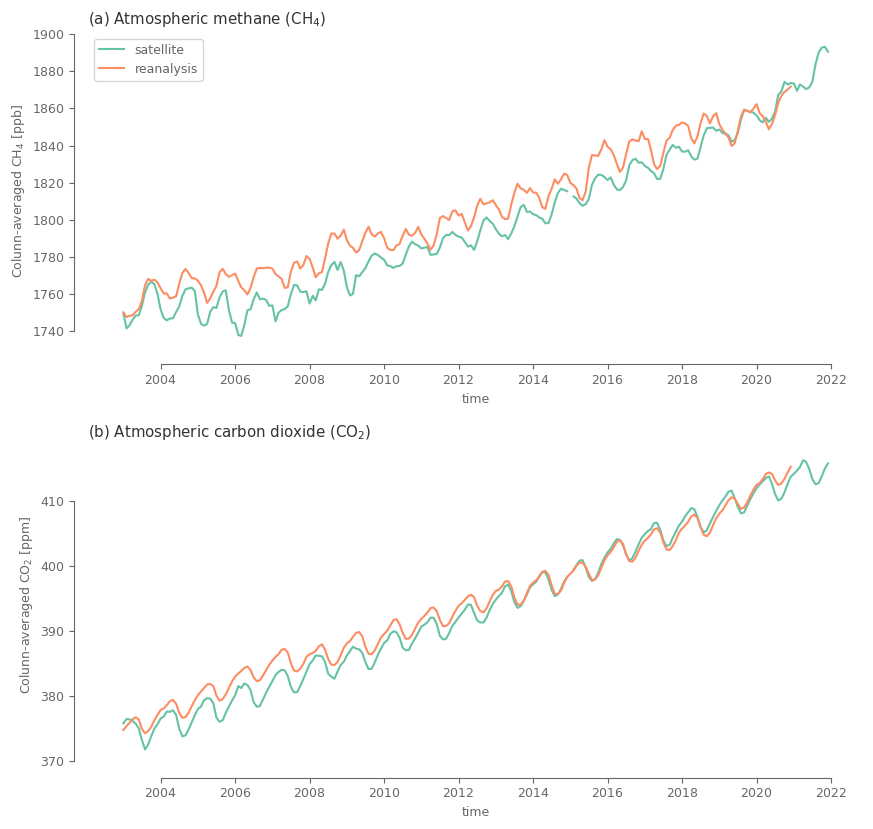

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(10, 9.5)) # define figure layout
axes = axes.flatten()
for i_abc, i_ax, i_dom in zip(ABC, axes, spatial_aver.ghg): # loop through the axes and the GHG
    subtitle = f'({i_abc}) {aux_var[i_dom.values.tolist()]["name"]} ({aux_var[i_dom.values.tolist()]["shortname"]})' # define eubtitle
    y_label = f'Colunn-averaged {aux_var[i_dom.values.tolist()]["shortname"]} [{aux_var[i_dom.values.tolist()]["units"]}]' # define y label
    spatial_aver.sel(ghg=i_dom, region='Global').plot.line(hue='type', ax=i_ax, label=spatial_aver.type.values) # plot data colured based on dataset

    i_ax.set_title(subtitle) # add subtitle
    i_ax.set_ylabel(y_label) # add y label
    sns.despine(ax=i_ax, trim=True, offset=10) # trim the axes
    i_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # correct the date format on x axis (needed because of the above trimming)

axes[0].legend() # add legend in upper plot
axes[1].get_legend().remove() # remove legend from lower plot

fig.subplots_adjust(hspace=.3) # define space between plots

plt.show()

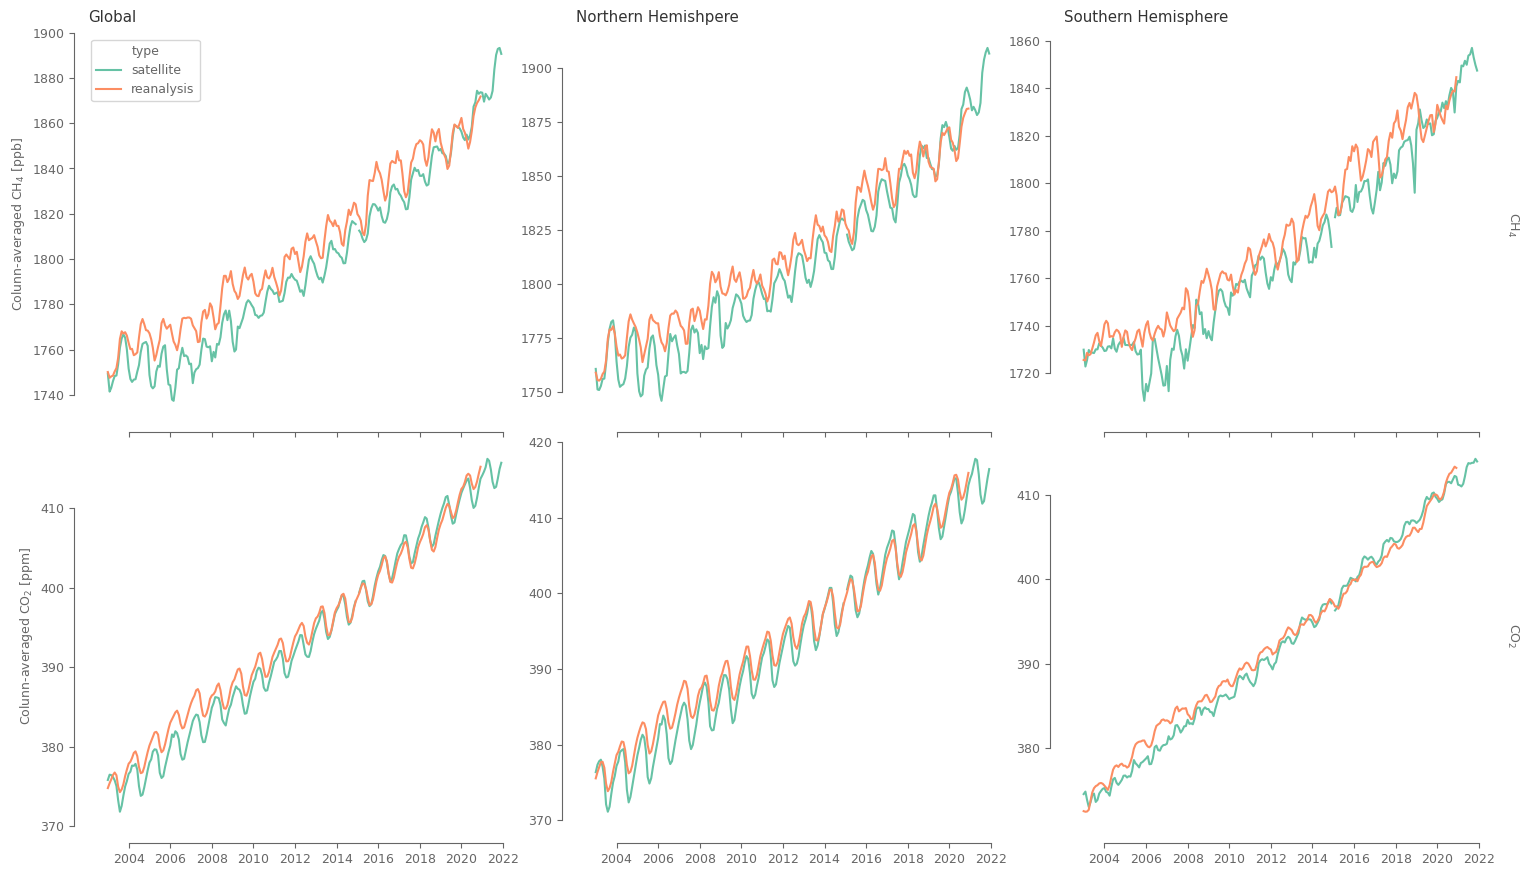

In [35]:
p = spatial_aver.plot(hue='type', col='region', row='ghg', sharey=False, add_legend=False, figsize=(15, 9)) # multiplot using xarray
p.add_legend(bbox_to_anchor=(0.11, .92)) # change location of the legend
for i_ax, ax in enumerate(p.axs.flatten()): # loop through all suplots
    sns.despine(ax=ax, trim=True, offset=10) # trim axes
    if i_ax>=len(region_of_interest): # for the lower subplots change the format of the xticklabels (upper plots don't have xticklabels)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.set_xlabel(None) # remove x label

[p.axs.flatten()[i].set_title(j) for i, j in enumerate(spatial_aver.region.values)] # change titles on columns (top on upper subplot)

for i_ax, ax in enumerate(p.axs.flatten()[len((spatial_aver.region))-1::len((spatial_aver.region))]): # change tiles on rows (right of last subplot)
    text_obj = ax.texts[0] # get text object
    text_str = text_obj.get_text().split(' = ')[1] # keep the part of the object indicating the GHG used
    text_obj.set_text(aux_var[text_str]["shortname"]) # replace the name with the values from the aux_var
    # define y label to be placed on left of the first subplot of each row
    y_label = f'Colunn-averaged {aux_var[text_str]["shortname"]} [{aux_var[text_str]["units"]}]' # define y label on 
    p.axs.flatten()[i_ax*len(spatial_aver.region)].set_ylabel(y_label) # set y label in the plot

plt.show()

Both satellites and reanalysis data indicate the strong increasing trend for both GHG, with the trend being of similar magnitude.</br>
At the same time we can observe some differences:</br>
For the CO2 data the differences are mainly in the magnitude of the concentrations for around the first half of the data (2003-2013). For the CH4 though, the differences are more substantial, and for most of the analysed period. These differences can be related to the methodology for generating the products, and the fact that satellite data are not complete in space and time, so there could be important information omitted. Also note that the differences between datasets are stronger in the southern hemisphere, that has fewer observations and reduced network (in space and time) of measurement stations.

<div class="alert alert-block alert-success">
Now that we have a better understanding about the GHG let's follow our next chapter, to find out what is happening in Earth's temperature.
</div>